In [1]:
# import sqlAlchemy dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.dialects import postgresql

In [2]:
# import the PostgreSQL confidential values
from config import postgresql_key, postgresql_port, postgresql_host, postgresql_db, postgresql_user

In [3]:
# create the engine
engine = create_engine(f"postgresql+psycopg2://{postgresql_user}:{postgresql_key}@{postgresql_host}/{postgresql_db}")

In [4]:
# create the base reflector and print tables
Base = automap_base()
Base.prepare(engine, reflect = True)
Base.classes.keys()

['employees', 'titles', 'dept_emp', 'departments', 'dept_manager', 'salaries']

In [5]:
# create the mapped objects
Employees = Base.classes.employees
Salaries = Base.classes.salaries
Titles = Base.classes.titles

In [6]:
# create the constructor session
session = Session(engine)

In [7]:
# construct the SQL statement
sqlQuery = session.query(Employees.emp_no, Salaries.salary, Titles.title)\
                        .join(Salaries, Employees.emp_no == Salaries.emp_no)\
                        .join(Titles, Employees.emp_title_id == Titles.title_id)

# define the statement in a string
sqlStatement = str(sqlQuery.statement.compile(dialect = postgresql.dialect()))

# close the session
session.close()

In [26]:
# import pandas, scipy, and matplotlib dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [9]:
# connect the engine
conn = engine.connect()

In [11]:
# read the data into Pandas
data = pd.read_sql(sqlStatement, conn)
data.head()

,emp_no,salary,title
0,10005,78228,Staff
1,10010,72488,Engineer
2,10011,42365,Staff
3,10018,55881,Senior Engineer
4,10035,41538,Senior Engineer


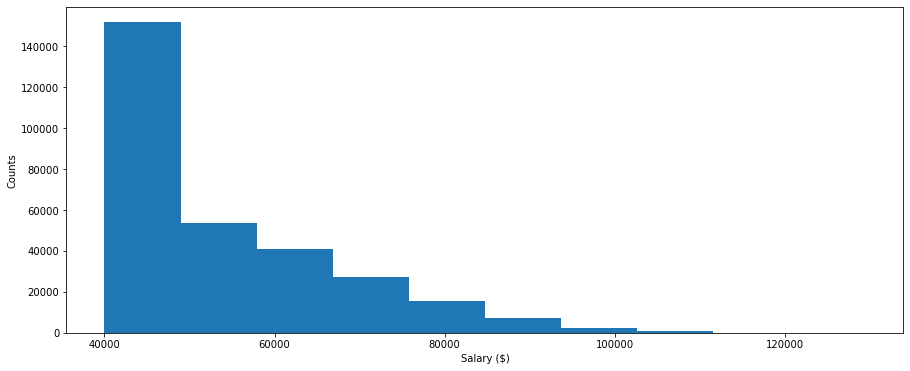

NormaltestResult(statistic=20.226152908533024, pvalue=4.054587721277819e-05)


In [30]:
# show the distribution of salaries and their frequencies
plt.figure(figsize = (15, 6))
plt.hist(data["salary"])
plt.xlabel("Salary ($)")
plt.ylabel("Counts")
plt.show()

In [18]:
# create the grouped DataFrame
grouped_df = data.groupby(["title"]).mean()
grouped_df.head()

,emp_no,salary
title,,
Assistant Engineer,252992.595373,48564.434447
Engineer,253654.345919,48535.336511
Manager,110780.833333,51531.041667
Senior Engineer,253038.749885,48506.799871
Senior Staff,254481.798969,58550.172704


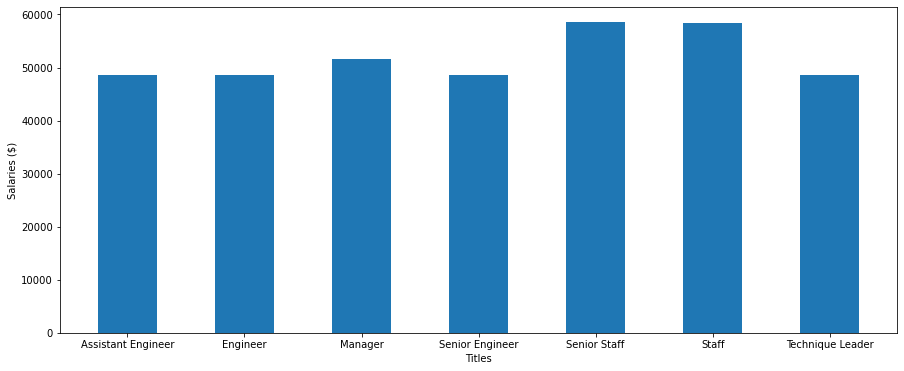

In [33]:
# show the distribution of salaries by title
plt.figure(figsize = (15, 6))
plt.bar([i for i in range(len(grouped_df.index))], grouped_df["salary"], width = 0.5, bottom = 0, align = "center")
plt.xticks([i for i in range(len(grouped_df.index))], grouped_df.index)
plt.xlabel("Titles")
plt.ylabel("Salaries ($)")
plt.show()

In [ ]:
# release the resources
conn.close()
engine.dispose()